In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colormaps
from PIL import Image


Desenvolver uma ferramenta em Python que implemente e compare a eficácia de vários algoritmos de compressão aplicados a imagens. A ferramenta deve permitir compressão e descompressão de imagens em formatos como PNG e JPEG, além de comparar a eficiência dos algoritmos em termos de taxa de compressão e qualidade da imagem.

In [2]:
def converter_escala_cinza(imagem):
    return imagem.convert('L')

## Imagem de teste 

In [3]:
image_path = "black mage.png"

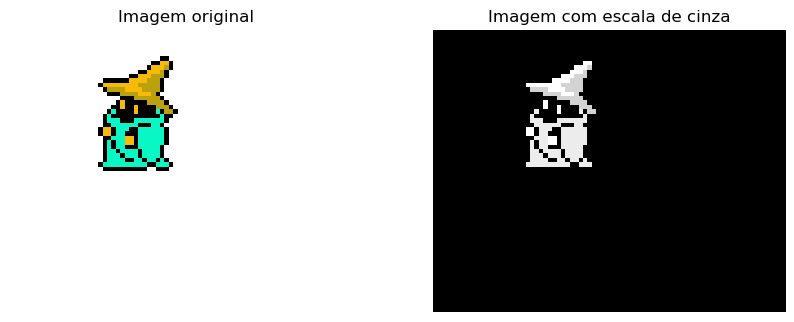

In [4]:
black_mage = np.array(Image.open(image_path))
black_mage_cinza = np.array(converter_escala_cinza(Image.open(image_path)))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagem original")
plt.axis('off')
plt.imshow(black_mage)
plt.subplot(1, 2, 2)
plt.title("Imagem com escala de cinza")
plt.imshow(black_mage_cinza, cmap=colormaps.get_cmap("gray"))
plt.axis('off')

plt.show()

## Implementar os Algoritmos de Compressão

### Compressão de Imagem com codificação aritmética

In [5]:
import numpy as np
from decimal import Decimal, getcontext

getcontext().prec = 5000

def get_probability_table(frequency_table):
    total_frequency = sum(frequency_table.values())
    probability_table = {}
    for key, value in frequency_table.items():
        probability_table[key] = value/total_frequency

    return probability_table

def process_stage(probability_table, stage_min, stage_max):
    stage_probs = {}
    stage_domain = stage_max - stage_min
    for term_idx in range(len(probability_table.items())):
        term = list(probability_table.keys())[term_idx]
        term_prob = Decimal(probability_table[term])
        cum_prob = term_prob * stage_domain + stage_min
        stage_probs[term] = [stage_min, cum_prob]
        stage_min = cum_prob
    return stage_probs

def get_encoded_value(last_stage_probs):
    last_stage_probs = list(last_stage_probs.values())
    last_stage_values = []
    for sublist in last_stage_probs:
        for element in sublist:
            last_stage_values.append(element)

    last_stage_min = min(last_stage_values)
    last_stage_max = max(last_stage_values)
    encoded_value = (last_stage_min + last_stage_max)/2

    return encoded_value


def encode(msg, probability_table):
    msg = list(msg)

    stage_min = Decimal(0.0)
    stage_max = Decimal(1.0)
    
    stage_probs = None
    for msg_term_idx in range(len(msg)):
        stage_probs = process_stage(probability_table, stage_min, stage_max)

        msg_term = msg[msg_term_idx]
        stage_min = stage_probs[msg_term][0]
        stage_max = stage_probs[msg_term][1]

    last_stage_probs = process_stage(probability_table, stage_min, stage_max)
    
    return get_encoded_value(last_stage_probs)

def decode(encoded_msg, msg_length, probability_table):
    decoded_msg = []
    stage_min = Decimal(0.0)
    stage_max = Decimal(1.0)

    for idx in range(msg_length):
        stage_probs = process_stage(probability_table, stage_min, stage_max)

        for msg_term, value in stage_probs.items():
            if encoded_msg >= value[0] and encoded_msg <= value[1]:
                break

        decoded_msg.append(msg_term)

        stage_min = stage_probs[msg_term][0]
        stage_max = stage_probs[msg_term][1]
    return np.array(decoded_msg)

In [6]:
mensagem = black_mage_cinza.flatten()

frequency_table = {}
for term in mensagem:
    if term in frequency_table:
        frequency_table[term] += 1
    else:
        frequency_table[term] = 1
probability_table = get_probability_table(frequency_table)

encoded_msg = encode(msg=mensagem, probability_table=probability_table)

encoded_msg_aritmetico = encoded_msg
probability_table_aritmetico = probability_table

In [7]:
decoded_msg = decode(encoded_msg=encoded_msg, msg_length=len(mensagem), probability_table=probability_table)

In [8]:
decoded_msg.size, mensagem.size

(5120, 5120)

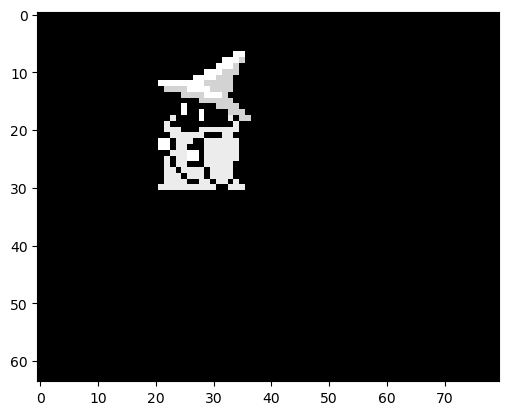

In [9]:
decoded_msg = decoded_msg.reshape(black_mage_cinza.shape)

plt.imshow(decoded_msg, cmap=colormaps.get_cmap("gray"))
plt.show()

### Compressão de Imagem com Huffman 

In [10]:
from collections import Counter, namedtuple
from heapq import heapify, heappop, heappush

# message = "AUOOOU EAEEE ALOO AAAA :)"
mensagem = black_mage_cinza.flatten()

frequency_table = Counter(mensagem)

Node = namedtuple('Node', ['count', 'letter', 'left', 'right'])

nodes = [Node(count, letter, None, None) 
         for (letter, count) in frequency_table.items()]

heap = nodes.copy()
heapify(heap)

In [11]:
def make_tree(heap):
    root = None
    while len(heap) > 0:
        if root is None:
            right = heappop(heap)
            left = heappop(heap)
            root = Node(right.count + left.count, '\0', left, right)
        else:
            left = heappop(heap)
            old_root = root
            root = Node(old_root.count + left.count, '\0', left, old_root)
    return root

root = make_tree(heap)
tree = root

In [12]:
import networkx as nx

def add_edges(parent, G):
    if parent is None:
        return
    
    for child in (parent.left, parent.right):
        if child:
            G.add_edge(parent, child)
            add_edges(child, G)
            
G = nx.DiGraph()
add_edges(tree, G)

def get_labels(parent, labels):
    if parent is None:
        return
    
    if parent.letter == '\0':
        labels[parent] = parent.count
    else:
        labels[parent] = parent.letter
        
    get_labels(parent.left, labels)
    get_labels(parent.right, labels)
    

def get_edge_labels(parent, edge_labels):
    if parent is None:
        return
    
    if parent.left:
        edge_labels[parent, parent.left] = '0'
        get_edge_labels(parent.left, edge_labels)
        
    if parent.right:
        edge_labels[parent, parent.right] = '1'
        get_edge_labels(parent.right, edge_labels)

labels = {}
get_labels(tree, labels)

In [13]:
from EoN import hierarchy_pos

def draw_tree(tree):
    G = nx.DiGraph()
    add_edges(tree, G)
    pos = hierarchy_pos(G)
    labels = {}
    get_labels(tree, labels)
    edge_labels = {}
    get_edge_labels(tree, edge_labels)
    nx.draw(G, pos, labels=labels, alpha=0.4)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='C1')

#draw_tree(tree)

In [14]:
def is_leaf(node):
    return node.left is None and node.right is None

def make_table(node, path, table):
    if node is None:
        return
    
    if is_leaf(node):
        table[node.letter] = path
        return
    
    make_table(node.left, path+'0', table)
    make_table(node.right, path+'1', table)

In [15]:
def encode(s, table):
    t = [table[letter] for letter in s]
    return ''.join(t)

def decode(s, table):
    result = []
    while s:
        for k in table:
            if s.startswith(table[k]):
                result.append(k)
                s = s[len(table[k]):]
    return np.array(result)

In [16]:
table = {}
make_table(tree, '', table)

code = encode(mensagem, table)

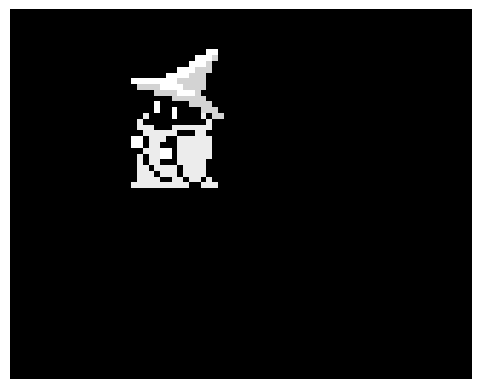

In [17]:
decoded_msg = decode(code, table)
decoded_msg = decoded_msg.reshape(black_mage_cinza.shape)

plt.axis('off')
plt.imshow(decoded_msg, cmap=colormaps.get_cmap("gray"))
plt.show()

### Compressão de Imagem com JPEG

In [18]:
from PIL import Image
image = converter_escala_cinza(Image.open(image_path))
image.save('./black_mage_jpeg.jpg', 'JPEG', quality=50)

## Comparação dos Algoritmos

### Tamanho da imagem cinza

In [19]:
import os
gray_image_path = 'black_mage_gray.png'
image = converter_escala_cinza(Image.open(image_path))
image.save(gray_image_path)

# Get the size of the grayscale image file
file_size = os.path.getsize(gray_image_path)

print(f"{file_size} bytes")

267 bytes


### Compressão de Imagem com codificação aritmética

Utilizando o código disponibilizado no github:

[]

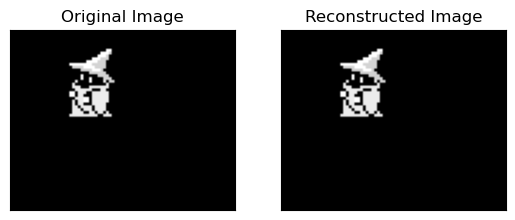

In [21]:
from ae import ArithmeticEncoding
getcontext().prec = 444

im = black_mage_cinza
msg = black_mage_cinza.flatten()
hist, bin_edges = np.histogram(a=im,
                                  bins=range(0, 257))
frequency_table = {key: value for key, value in zip(bin_edges[0:256], hist)}


AE = ArithmeticEncoding(frequency_table=frequency_table)

# Encode the message
encoded_msg, encoder, interval_min_value, interval_max_value = AE.encode(msg=msg, 
                                                                         probability_table=AE.probability_table)

# Decode the message
decoded_msg, decoder = AE.decode(encoded_msg=encoded_msg, 
                                 msg_length=len(msg),
                                 probability_table=AE.probability_table)

# Reshape the image to its original shape.
decoded_msg = np.reshape(decoded_msg, im.shape)

# Show the original and decoded images.
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im, cmap="gray")
ax[0].set_title("Original Image")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(decoded_msg, cmap="gray")
ax[1].set_title("Reconstructed Image")
ax[1].set_xticks([])
ax[1].set_yticks([])

In [23]:
# Calculate the size of encoded_msg_aritmetico
encoded_msg_size = len(str(encoded_msg).encode('utf-8'))

# Calculate the size of probability_table_aritmetico
probability_table_size = 0
for key, value in AE.probability_table.items():
    probability_table_size += len(str(key).encode('utf-8'))
    probability_table_size += len(str(value).encode('utf-8'))

# Total size
total_size = encoded_msg_size + probability_table_size

print(f"Tamanho de encoded_msg_aritmetico: {encoded_msg_size} bytes")
print(f"Tamanho de probability_table_aritmetico: {probability_table_size} bytes")
print(f"Tamanho total: {total_size} bytes")

Tamanho de encoded_msg_aritmetico: 449 bytes
Tamanho de probability_table_aritmetico: 1460 bytes
Tamanho total: 1909 bytes


### Compressão de Imagem com Huffman

In [24]:
code_size = len(str(code).encode('utf-8'))
print(f"Tamanho de code: {code_size} bytes")

table_size = 0
for key, value in table.items():
    table_size += len(str(key).encode('utf-8'))
    table_size += len(str(value).encode('utf-8'))

print(f"Tamanho de table: {table_size} bytes")

Tamanho de code: 5393 bytes
Tamanho de table: 19 bytes
